In [1]:
import numpy as np
from os import path
from skimage import io
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import ipywidgets as widgets
from sklearn.metrics import accuracy_score

In [2]:
import A1.models, A2.models, B1.models, B2.models

2023-01-04 12:33:50.675657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Function for loading data

In [3]:
LABELS = 'labels.csv'
DATASETS = 'Datasets'
IMGS = 'img'
TEST = '_test'

def load_data(folder, feature_col, file_col, load_image, augment=False):
    filenames, y = np.genfromtxt(
        path.join(DATASETS,folder,LABELS),
        usecols=(file_col,feature_col),
        dtype='U10,i8',
        unpack=True,
        skip_header=1,
        delimiter='\t'
    )
    y = np.maximum(y,0) # convert -1 label to 0
    imagedir = path.join(DATASETS,folder,IMGS)
    n = len(filenames)
    shape = load_image(path.join(imagedir,filenames[0])).shape # get first image to get shape
    X = np.empty((n*2 if augment else n, *shape), dtype=np.uint8) # pre-define X, much more efficient than concatenating arrays
    for i in tqdm(range(n), desc=folder): # tqdm displays a nice loading bar
        X[i] = load_image(path.join(imagedir,filenames[i]))
    if augment:
        X[n:] = X[:n,:,::-1]  # copy images, but reverse left to right
        y = np.tile(y,2) # duplicate labels
    print(f'Loaded {X.nbytes:,} bytes')
    return X, y


Each task uses a different comibination of dataset, feature_col, file_col, and module:

In [4]:
TASKS = {'A1':('celeba',2,1,A1), 'A2':('celeba',3,1,A2), 'B1':('cartoon_set',2,3,B1),'B2':('cartoon_set',1,3,B2)}
task = widgets.Dropdown(options=TASKS, description='Task')

In [6]:
task

Dropdown(description='Task', index=2, options={'A1': ('celeba', 2, 1, <module 'A1' (namespace)>), 'A2': ('cele…

In [7]:
dataset, feature_col, file_col, task_module = task.value

In [8]:
augment = task.label.startswith('A')
X, y = load_data(dataset, feature_col, file_col, task_module.models.load_image, augment=augment)

cartoon_set:   0%|          | 0/10000 [00:00<?, ?it/s]

Loaded 120,000,000 bytes


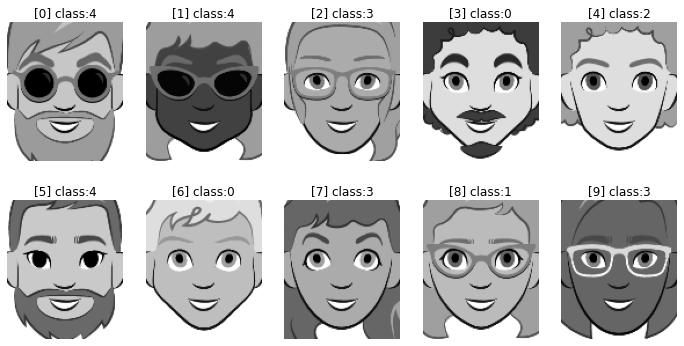

In [9]:
plt.figure(figsize=(12,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title(f'[{i}] class:{y[i]}')
    plt.imshow(X[i], cmap='gray')
plt.show()

In [10]:
models = widgets.Dropdown(options=task_module.models.models, description='Model')

In [12]:
models

Dropdown(description='Model', index=1, options={'Best: Decision Tree with max depth of 7': <B1.models.Decision…

In [13]:
model = models.value

In [14]:
X_test, y_test = load_data(dataset+TEST, feature_col, file_col, task_module.models.load_image)

cartoon_set_test:   0%|          | 0/2500 [00:00<?, ?it/s]

Loaded 30,000,000 bytes


In [ ]:
print(f"Accuracy on trained data: {model.fit(X, y):.2%}")

Peforming Decision Tree Fitting


In [20]:
y_pred = model.predict(X_test)

In [21]:
print(f"Accuracy on test data: {accuracy_score(y_test,y_pred):.1%}")

Accuracy on test data: 100.0%


There were 1 wrong predictions out of 2500


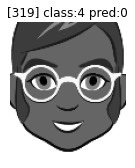

In [22]:
wrong, = np.nonzero(y_test!=y_pred)
plt.figure(figsize=(12,3))
print(f'There were {len(wrong)} wrong predictions out of {len(y_test)}')
for w,i in enumerate(wrong[:100]): # show first 100 that are wrong
    plt.subplot(1, 5, w%5+1)
    plt.axis('off')
    plt.title(f'[{i}] class:{y_test[i]} pred:{y_pred[i]}')
    plt.imshow(X_test[i], cmap='gray')
    if w%5==4:
        plt.show()
        plt.figure(figsize=(12,3))